# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

---
## Step 0: Load The Data

In [1]:
# Imports
%matplotlib inline
import pickle
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib.ticker as plttick
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.contrib.layers import flatten
import math
import matplotlib.image as mpimg
import os
import scipy.misc
import skimage.exposure as imgexp
import skimage.transform as imgtf
import skimage.filters as imgfilt
plt.rcParams['image.cmap'] = 'gray'


In [2]:
# Check expected data consistency
def check_consistency(x, y):
    assert (len(x) == len(y))
    assert (len(x.shape) == 4)
    assert (x.shape[1] == x.shape[2] == 32)
    assert (x.shape[3] == 3)

# Deserialize data from pickle
def load_data(file_name):
    with open(file_name, mode='rb') as f:
        data = pickle.load(f)
        return data['features'], data['labels']

# Serialize data to pickle
def write_data(file_name, x, y):
    with open(file_name, mode='wb') as f:
        data = {"features": x, "labels": y}
        pickle.dump(data, f)
        
# Create extra dimension for gray value (for neural network)
def add_gray_dimension(images):
    return images[..., np.newaxis]

# Remove extra dimension for gray value (for image processing)
def drop_gray_dimension(images):
    return images.reshape(images.shape[:-1])

# Dump images into directory
def dump_images(file_directory, images, classes):
    if len(images.shape) > 3 and images.shape[3] == 1:
        images = drop_gray_dimension(images)
    for i in range(images.shape[0]):
        imgdir = "{}/{}".format(file_directory, classes[i])
        if not os.path.exists(imgdir):
            os.makedirs(imgdir)
        scipy.misc.imsave("{}/{}.jpg".format(imgdir, i), images[i])

# Load and verify the data
x_train, y_train = load_data("data/train.p")
check_consistency(x_train, y_train)

x_validation, y_validation = load_data("data/valid.p")
check_consistency(x_validation, y_validation)

x_test, y_test = load_data("data/test.p")
check_consistency(x_test, y_test)

class_names = pd.read_csv("data/signnames.csv").as_matrix()

#r = np.random.random_integers(0, len(x_train), 100)
#fig = plt.figure(figsize=(10,10))
#fig.subplots_adjust(hspace = 0.1, wspace = 0.1)
#for i in range(len(r)):
#    axis = fig.add_subplot(10, 10, i + 1)
#    axis.tick_params(bottom='off', top='off', left='off', right='off', labelbottom='off', labeltop='off', labelleft='off', labelright='off')
#    axis.imshow(x_train[r[i]])
#plt.show()

---

## Step 1: Dataset Summary & Exploration


### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [3]:
# Number of training examples
n_train = x_train.shape[0]

# Number of validation examples
n_validation = x_validation.shape[0]

# Number of testing examples.
n_test = x_test.shape[0]

# Shape of a traffic sign image
image_shape = [x_test.shape[1], x_test.shape[2]]

# Depth of a traffic sign image
image_depth = x_test.shape[3]

# Unique classes/labels there are in the dataset.
class_counts = np.stack(np.unique(y_train, return_counts=True), axis=1)
n_classes = class_counts.shape[0]

print("Training Set:   {} samples".format(n_train))
print("Validation Set: {} samples".format(n_validation))
print("Test Set:       {} samples".format(n_test))
print("Image Shape:    {}".format(image_shape))
print("Image Depth:    {}".format(image_depth))
print("# Classes:      {}".format(n_classes))

Training Set:   34799 samples
Validation Set: 4410 samples
Test Set:       12630 samples
Image Shape:    [32, 32]
Image Depth:    3
# Classes:      43


### Include an exploratory visualization of the dataset

Data Exploration:

[000]:  180 x "Speed limit (20km/h)":


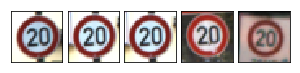


[001]: 1980 x "Speed limit (30km/h)":


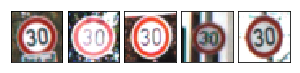


[002]: 2010 x "Speed limit (50km/h)":


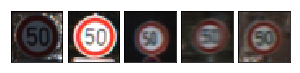


[003]: 1260 x "Speed limit (60km/h)":


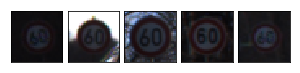


[004]: 1770 x "Speed limit (70km/h)":


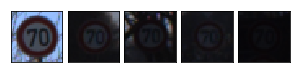


[005]: 1650 x "Speed limit (80km/h)":


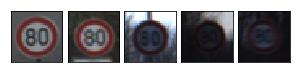


[006]:  360 x "End of speed limit (80km/h)":


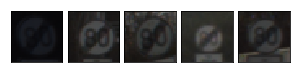


[007]: 1290 x "Speed limit (100km/h)":


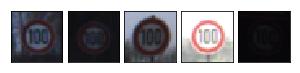


[008]: 1260 x "Speed limit (120km/h)":


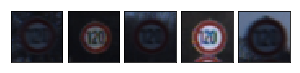


[009]: 1320 x "No passing":


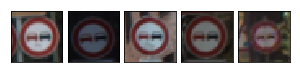


[010]: 1800 x "No passing for vehicles over 3.5 metric tons":


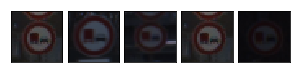


[011]: 1170 x "Right-of-way at the next intersection":


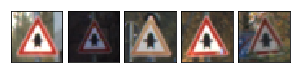


[012]: 1890 x "Priority road":


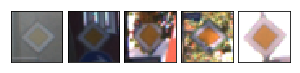


[013]: 1920 x "Yield":


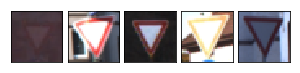


[014]:  690 x "Stop":


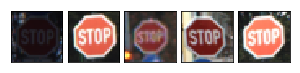


[015]:  540 x "No vehicles":


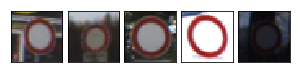


[016]:  360 x "Vehicles over 3.5 metric tons prohibited":


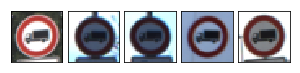


[017]:  990 x "No entry":


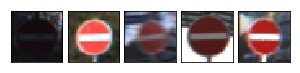


[018]: 1080 x "General caution":


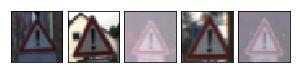


[019]:  180 x "Dangerous curve to the left":


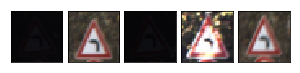


[020]:  300 x "Dangerous curve to the right":


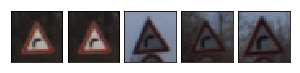


[021]:  270 x "Double curve":


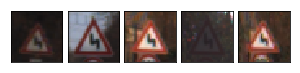


[022]:  330 x "Bumpy road":


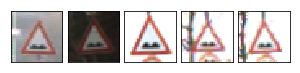


[023]:  450 x "Slippery road":


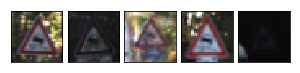


[024]:  240 x "Road narrows on the right":


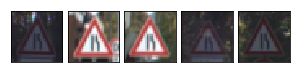


[025]: 1350 x "Road work":


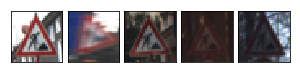


[026]:  540 x "Traffic signals":


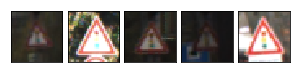


[027]:  210 x "Pedestrians":


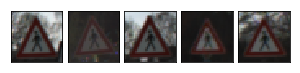


[028]:  480 x "Children crossing":


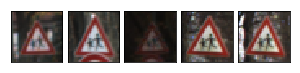


[029]:  240 x "Bicycles crossing":


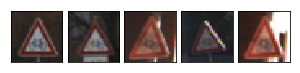


[030]:  390 x "Beware of ice/snow":


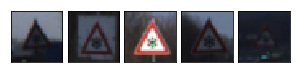


[031]:  690 x "Wild animals crossing":


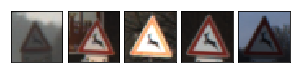


[032]:  210 x "End of all speed and passing limits":


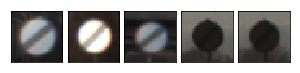


[033]:  599 x "Turn right ahead":


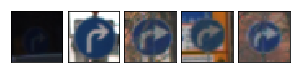


[034]:  360 x "Turn left ahead":


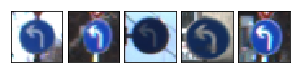


[035]: 1080 x "Ahead only":


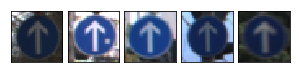


[036]:  330 x "Go straight or right":


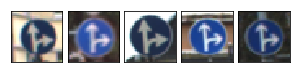


[037]:  180 x "Go straight or left":


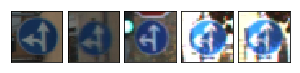


[038]: 1860 x "Keep right":


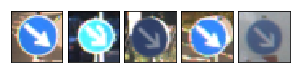


[039]:  270 x "Keep left":


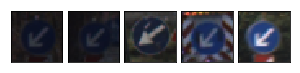


[040]:  300 x "Roundabout mandatory":


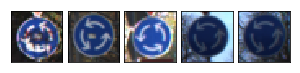


[041]:  210 x "End of no passing":


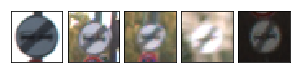


[042]:  210 x "End of no passing by vehicles over 3.5 metric tons":


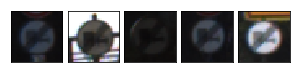

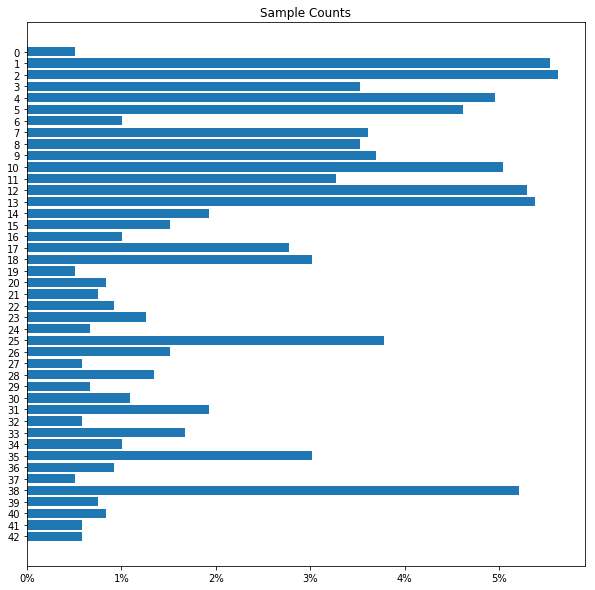

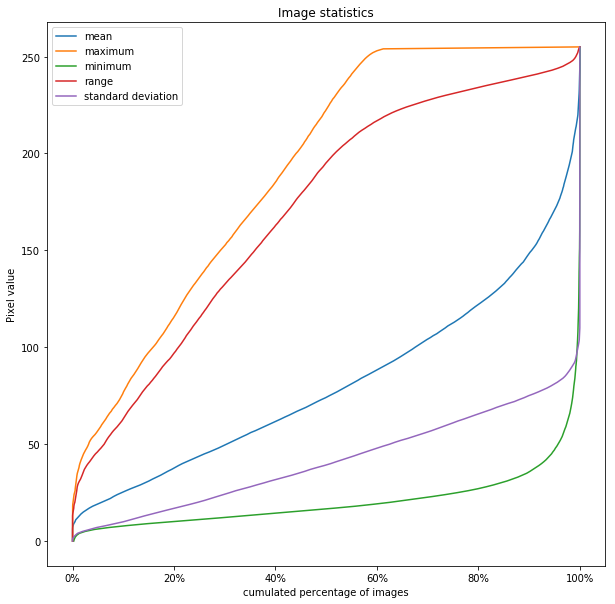

In [4]:
# Randomly selects n samples of each unique class
def select_samples(images, labels, classes, n_select=5):
    samples = []
    for c in classes:
        c_labels = np.where(labels == c[0])[0]
        if c_labels.shape[0] > 0:
            selection = images[np.random.choice(c_labels, n_select)]
            samples.append(selection)
    return np.array(samples)

def print_samples(names, counts, samples):
    n_samples = len(samples[0])
    n_classes = len(names)
    for i in range(n_classes):
        print("[{:0>3}]:{:>5} x \"{}\":".format(names[i][0], counts[i][1], names[i][1]))
        fig, axes = plt.subplots(nrows=1, ncols=n_samples, figsize=(n_samples, 1))
        fig.subplots_adjust(hspace = 0.1, wspace = 0.1)
        for j in range(n_samples):
            if n_samples == 1:
                ax = axes
            else:
                ax =axes[j]
            ax.tick_params(bottom='off', top='off', left='off', right='off', labelbottom='off', labeltop='off', labelleft='off', labelright='off')
            ax.imshow(samples[i][j])
        plt.show()
        print()

def print_class_counts(counts):  
    s_counts = np.sum(counts)   
    x = counts[:,1] / s_counts * 100
    y = counts[:,0]
    y_pos = np.arange(len(y))   
    fig, axis = plt.subplots(figsize=(10, 10))
    axis.barh(y_pos, x)
    axis.set_yticks(y_pos)
    axis.set_yticklabels(y)
    axis.xaxis.set_major_formatter(plttick.FormatStrFormatter('%.0f%%'))
    axis.invert_yaxis()  # labels read top-to-bottom
    axis.set_title('Sample Counts') 
    plt.show()

def print_image_stats(images):
    fig, axis = plt.subplots(figsize=(10, 10))
    x = np.arange(256)
    bins = np.arange(257)

    mean_hist = np.histogram(np.mean(images, axis=(1, 2, 3)), bins=bins)[0].cumsum() / len(images) * 100
    me, = axis.plot(mean_hist, x, label='mean')
 
    max_hist = np.histogram(np.max(images, axis=(1, 2, 3)), bins=bins)[0].cumsum() / len(images) * 100
    ma, = axis.plot(max_hist, x, label='maximum')
    
    min_hist = np.histogram(np.min(images, axis=(1, 2, 3)), bins=bins)[0].cumsum() / len(images) * 100
    mi, = axis.plot(min_hist, x, label='minimum')
    
    range_hist = np.histogram(np.max(images, axis=(1, 2, 3)) - np.min(images, axis=(1, 2, 3)), bins=bins)[0].cumsum() / len(images) * 100
    ra, = axis.plot(range_hist, x, label='range')
    
    std_hist = np.histogram(np.std(images, axis=(1, 2, 3)), bins=bins)[0].cumsum() / len(images) * 100
    st, = axis.plot(std_hist, x, label='standard deviation')
    
    
    plt.legend(handles=[me, ma, mi, ra, st])
    axis.xaxis.set_major_formatter(plttick.FormatStrFormatter('%.0f%%'))
    #axis.set_xscale('log')
    axis.set_title("Image statistics")
    axis.set_xlabel('cumulated percentage of images')
    axis.set_ylabel('Pixel value')
    plt.show()

print("Data Exploration:")
print()
samples_train = select_samples(x_train, y_train, class_names, 5)
print_samples(class_names, class_counts, samples_train)
print_class_counts(class_counts)
print_image_stats(x_train)
print()


### Augment the dataset

In [5]:
# Rotate right by random angle
def rotate_right(image):
    angle = random.randint(10, 15)
    image = imgtf.rotate(image, angle, mode='wrap', preserve_range=True)
    return np.clip(image, 0, 255).astype(np.uint8)

# Rotate left by random angle
def rotate_left(image):
    angle = -random.randint(10, 15)
    image = imgtf.rotate(image, angle, mode='wrap', preserve_range=True)
    return np.clip(image, 0, 255).astype(np.uint8)

# Scale up by random factor
def scale_up(image):
    scale_x = random.uniform(0.80, 0.90)
    scale_y = scale_x
    c = (image.shape[0] / 2 * (1 - scale_x), image.shape[1] / 2 * (1 - scale_y))
    transform = imgtf.AffineTransform(scale=(scale_x, scale_y), translation=c)
    image = imgtf.warp(image, transform, mode='wrap', preserve_range=True)
    return np.clip(image, 0, 255).astype(np.uint8)

# Scale down by random factor
def scale_down(image):
    scale_x = random.uniform(1.15, 1.25)
    scale_y = scale_x
    c = (image.shape[0] / 2 * (1 - scale_x), image.shape[1] / 2 * (1 - scale_y))
    transform = imgtf.AffineTransform(scale=(scale_x, scale_y), translation=c)
    image = imgtf.warp(image, transform, mode='wrap', preserve_range=True)
    return np.clip(image, 0, 255).astype(np.uint8)

# Squash horizonally by random factor
def squash(image):
    scale_x = random.uniform(1.2, 1.3)
    c = (image.shape[0] / 2 * (1 - scale_x), 0)
    transform = imgtf.AffineTransform(scale=(scale_x, 1.0), translation=c)
    image = imgtf.warp(image, transform, mode='wrap', preserve_range=True)
    return np.clip(image, 0, 255).astype(np.uint8)

# Offset right with random y movement
def offset_right(image):
    offset_x = 2
    offset_y = random.randint(-2, 2)
    transform = imgtf.AffineTransform(translation=(offset_x, offset_y))
    image = imgtf.warp(image, transform, mode='wrap', preserve_range=True)
    return np.clip(image, 0, 255).astype(np.uint8)

# Offset left with random y movement
def offset_left(image):
    offset_x = -2
    offset_y = random.randint(-2, 2)
    transform = imgtf.AffineTransform(translation=(offset_x, offset_y))
    image = imgtf.warp(image, transform, mode='wrap', preserve_range=True)
    return np.clip(image, 0, 255).astype(np.uint8)

# Shear right by random angle
def shear_right(image):
    angle = random.uniform(0.15, 0.25)
    c = (4 * angle, 2)
    transform = imgtf.AffineTransform(shear=angle, translation=c)
    image = imgtf.warp(image, transform, mode='wrap', preserve_range=True)
    return np.clip(image, 0, 255).astype(np.uint8)

# Shear left by random angle
def shear_left(image):
    angle = -random.uniform(0.15, 0.25)
    c = (4 * angle, 2)
    transform = imgtf.AffineTransform(shear=angle, translation=c)
    image = imgtf.warp(image, transform, mode='wrap', preserve_range=True)
    return np.clip(image, 0, 255).astype(np.uint8)

# Add horizontal motion blur
def blur(image):
    sigma = random.uniform(0.75, 1.0)
    image = imgfilt.gaussian(image, sigma=sigma, multichannel=True) * 255
    return np.clip(image, 0, 255).astype(np.uint8)

# Add color noise
def color_noise(image):
    sigma = random.uniform(10.0, 15.0)
    noise = np.random.normal(0.0, sigma, image.shape[0] * image.shape[1] * image.shape[2])
    noise = noise.reshape(image.shape[0], image.shape[1], image.shape[2])
    image = image.astype(np.float32)
    image += noise
    return np.clip(image, 0, 255).astype(np.uint8)

# Dictionary of supported augmentation operations
operations = {
    0: rotate_right,
    1: rotate_left,
    2: scale_up,
    3: scale_down,
    4: squash,
    5: offset_right,
    6: offset_left,
    7: shear_right,
    8: shear_left,
    9: blur,
    10: color_noise}

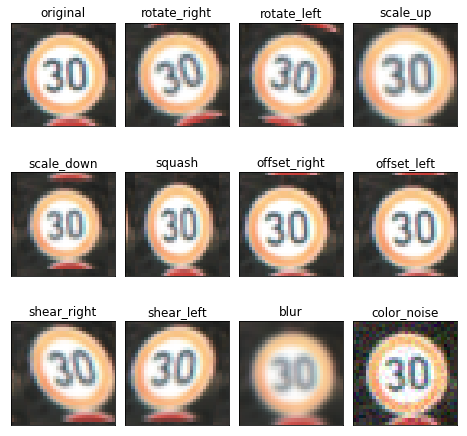

In [6]:
# Print the implemented augmentation operations
def print_operations(image):
    # Generate
    images = []
    images.append(("original", image))
    for operation in operations:
        images.append((operations[operation].__name__, operations[operation](image)))
    
    # Plot
    fig = plt.figure(figsize=(8, 8))
    fig.subplots_adjust(hspace = 0.1, wspace = 0.1)
    for i in range(len(images)):
        #print("{}:".format(operations[operation].__name__))
        axis = fig.add_subplot(3, 4, i + 1)
        axis.tick_params(bottom='off', top='off', left='off', right='off', labelbottom='off', labeltop='off', labelleft='off', labelright='off')
        axis.imshow(images[i][1])
        axis.set_title(images[i][0])
    plt.show()

print_operations(x_train[2272])
print()

Loading..


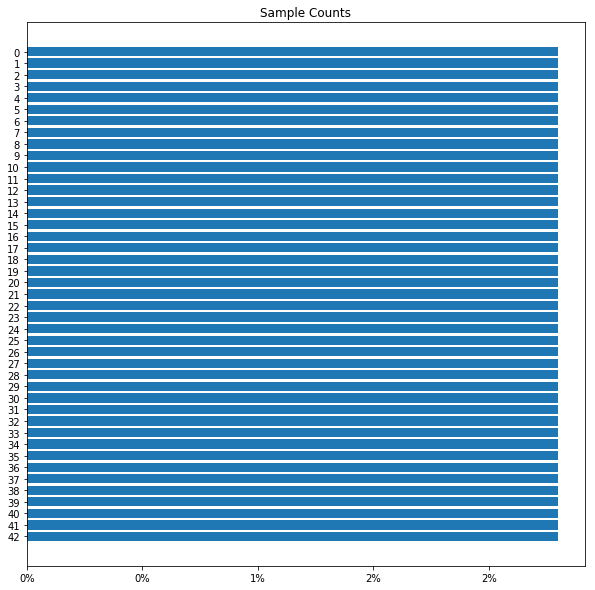

In [7]:
# Augment the data
def augment(x, y, file_name):
    if os.path.isfile(file_name):
        # Shortcut: load from file
        print("Loading..")
        x_aug, y_aug = load_data(file_name)
    else:
        max_uniques_count = np.max(uniques_count)
        processed_uniques_count = np.zeros_like(uniques_count)

        # Perform augmentation by random operation
        print("Augmenting..")
        x_aug = []
        y_aug = []

        for i in range(x.shape[0]):
            unique = y[i]
            num_to_generate = max_uniques_count - uniques_count[unique]
            multiplier = num_to_generate // uniques_count[unique]
            remainder = num_to_generate % uniques_count[unique]
            num_operations = multiplier + 1 if processed_uniques_count[unique] < remainder else multiplier
            if num_operations > 0:
                selection = np.random.choice([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], num_operations)
                for operation in selection:
                    x_aug.append(operations[operation](x[i]))
                    y_aug.append(unique)
            processed_uniques_count[unique] += 1

        assert (np.array_equal(uniques_count, processed_uniques_count))
        x_aug = np.array(x_aug)
        y_aug = np.array(y_aug)
        dump_images("augmented", x_aug, y_aug)
        write_data(file_name, x_aug, y_aug)
    return x_aug, y_aug

# Equalize unique class counts by generating samples
x_augmented, y_augmented = augment(x_train, y_train, "data/aug_train.p")
x_train = np.concatenate((x_train, x_augmented))
y_train = np.concatenate((y_train, y_augmented))
class_counts = np.stack(np.unique(y_train, return_counts=True), axis=1)
print_class_counts(class_counts)

----

## Step 2: Design and Test a Model Architecture


### Pre-process the Data Set (normalization, grayscale, etc.)

In [8]:
# Convert to YUV
def convert_to_YUV(images, y_only=False):
    YUV = np.array([
        [0.299, -0.14713, 0.615],
        [0.587, -0.28886, -0.51499],
        [0.114, 0.436, -0.10001]])
    Y_UV = np.array([
        [0.299],
        [0.587],
        [0.114]])
    images = images.astype(np.float32)
    images = np.dot(images, Y_UV) if y_only else np.dot(images, YUV)
    return images / 255.

# Intensity normalization + Center around 0
def normalize(img):
    minc = np.min(img)
    maxc = np.max(img)
    return (img - minc) / (maxc - minc) - 0.5

Preprocessing...
Loading..
Normalizing..
Loading..
Normalizing..
Loading..
Normalizing..
New Image Depth:    1

[000]: 2010 x "Speed limit (20km/h)":


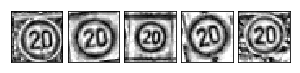


[001]: 2010 x "Speed limit (30km/h)":


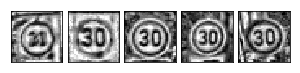


[002]: 2010 x "Speed limit (50km/h)":


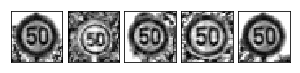


[003]: 2010 x "Speed limit (60km/h)":


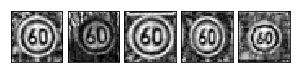


[004]: 2010 x "Speed limit (70km/h)":


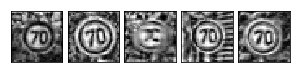


[005]: 2010 x "Speed limit (80km/h)":


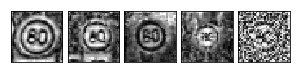


[006]: 2010 x "End of speed limit (80km/h)":


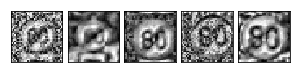


[007]: 2010 x "Speed limit (100km/h)":


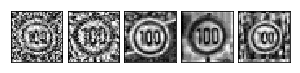


[008]: 2010 x "Speed limit (120km/h)":


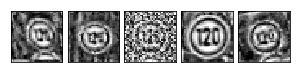


[009]: 2010 x "No passing":


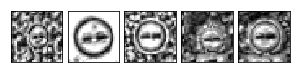


[010]: 2010 x "No passing for vehicles over 3.5 metric tons":


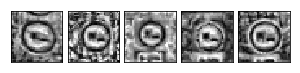


[011]: 2010 x "Right-of-way at the next intersection":


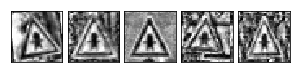


[012]: 2010 x "Priority road":


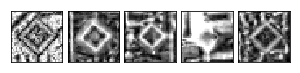


[013]: 2010 x "Yield":


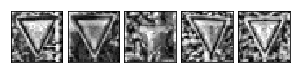


[014]: 2010 x "Stop":


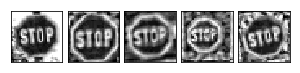


[015]: 2010 x "No vehicles":


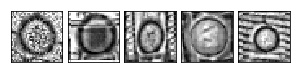


[016]: 2010 x "Vehicles over 3.5 metric tons prohibited":


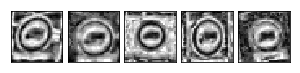


[017]: 2010 x "No entry":


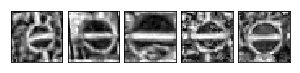


[018]: 2010 x "General caution":


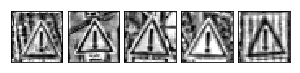


[019]: 2010 x "Dangerous curve to the left":


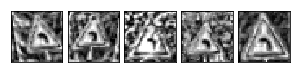


[020]: 2010 x "Dangerous curve to the right":


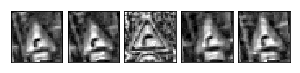


[021]: 2010 x "Double curve":


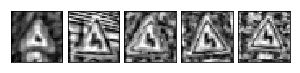


[022]: 2010 x "Bumpy road":


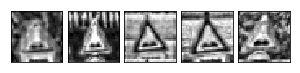


[023]: 2010 x "Slippery road":


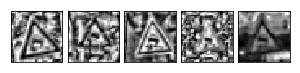


[024]: 2010 x "Road narrows on the right":


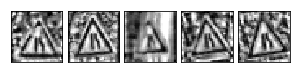


[025]: 2010 x "Road work":


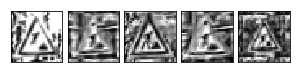


[026]: 2010 x "Traffic signals":


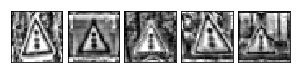


[027]: 2010 x "Pedestrians":


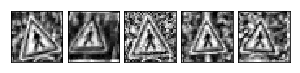


[028]: 2010 x "Children crossing":


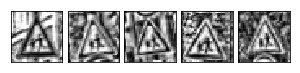


[029]: 2010 x "Bicycles crossing":


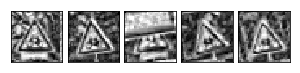


[030]: 2010 x "Beware of ice/snow":


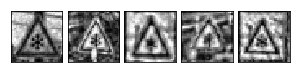


[031]: 2010 x "Wild animals crossing":


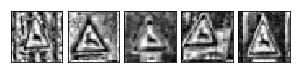


[032]: 2010 x "End of all speed and passing limits":


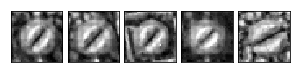


[033]: 2010 x "Turn right ahead":


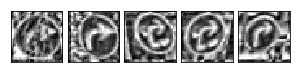


[034]: 2010 x "Turn left ahead":


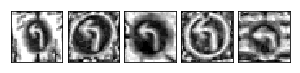


[035]: 2010 x "Ahead only":


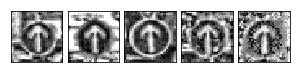


[036]: 2010 x "Go straight or right":


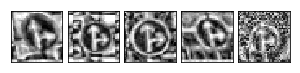


[037]: 2010 x "Go straight or left":


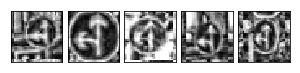


[038]: 2010 x "Keep right":


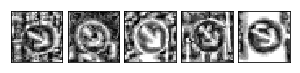


[039]: 2010 x "Keep left":


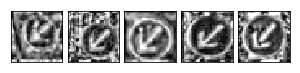


[040]: 2010 x "Roundabout mandatory":


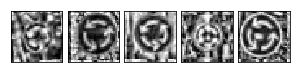


[041]: 2010 x "End of no passing":


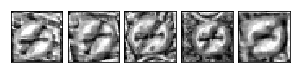


[042]: 2010 x "End of no passing by vehicles over 3.5 metric tons":


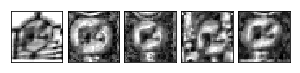

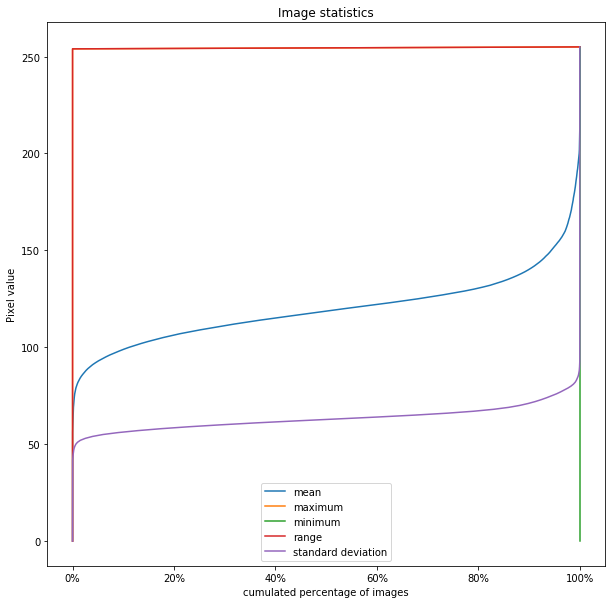

In [9]:
# Preprocess the data
def pre_proccess(x, y, file_name):
    if os.path.isfile(file_name):
        # Shortcut: load from file
        print("Loading..")
        x, y = load_data(file_name)
    else:
        # Actually preprocess
        print("Equalizing..")
        x = x.astype(np.float32)
        
        # Convert to "Y" brightness as proposed by LeCun
        x = convert_to_YUV(x, True)
        x = drop_gray_dimension(x)
        
        # Equalize local grid histograms using CLAHE
        for i in range(x.shape[0]):
            x[i] = imgexp.equalize_adapthist(x[i], kernel_size=4)
            
        # Save result
        dump_images("processed", x_train, y_train)
        x = add_gray_dimension(x)
        write_data(file_name, x, y)

    # Normalize around 0
    print("Normalizing..")
    for i in range(x.shape[0]):
        x[i] = normalize(x[i])
    return x
    
print("Preprocessing...")
x_train = pre_proccess(x_train, y_train, "data/pre_train.p")
x_validation = pre_proccess(x_validation, y_validation, "data/pre_valid.p")
x_test = pre_proccess(x_test, y_test, "data/pre_test.p")
if image_depth != x_train.shape[3]:
    image_depth = x_train.shape[3]
    print("New Image Depth:    {}".format(image_depth))
    print()
    
samples_train = select_samples(drop_gray_dimension(x_train), y_train, class_names, 5)
print_samples(class_names, class_counts, samples_train)
print_image_stats(((x_train + 0.5) * 255).astype(np.uint8))

### Model Architecture

In [10]:
# Define the architecture
def create_neural_network(x):
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1

    c1 = (3, 3)   # Convolution 1 size
    c2 = (3, 3)   # Convolution 2 size
    c3 = (3, 3)   # Convolution 3 size
    c1_depth = 21   # Filter between Convolution 1 and 2
    c2_depth = 43   # Filter between Convolution 2 and Convolution 3
    c3_depth = 54  # Filter between Convolution 3 and Linear Classifier Layer 1
    c1_dim = (math.ceil((x_train.shape[1] - c1[0] + 1) / 2), math.ceil((x_train.shape[2] - c1[1] + 1) / 2))
    c2_dim = (math.ceil((c1_dim[0] - c2[0] + 1) / 2), math.ceil((c1_dim[1] - c2[1] + 1) / 2))
    c3_dim = (math.ceil(c2_dim[0] / 2), math.ceil(c2_dim[1] / 2))
    f1_out = 240#542  # Nodes between Linear Classifier 1 and Linear Classifier Layer 2
    f2_out = 168#361   # Linear Classifier Layer 2 output Logits

    c1_out = math.ceil(c1_dim[0] / 4) * math.ceil(c1_dim[1] / 4) * c1_depth
    c2_out = math.ceil(c2_dim[0] / 2) * math.ceil(c2_dim[1] / 2) * c2_depth
    c3_out = math.ceil(c3_dim[0] / 1) * math.ceil(c3_dim[1] / 1) * c3_depth

    filters = {
        'conv10': tf.Variable(tf.truncated_normal([c1[0], c1[1], image_depth, c1_depth], mean=mu, stddev=sigma), name='f_conv10'),
        'conv20': tf.Variable(tf.truncated_normal([c2[0], c2[1], c1_depth, c2_depth], mean=mu, stddev=sigma), name='f_conv20'),
        'conv30': tf.Variable(tf.truncated_normal([c3[0], c3[1], c2_depth, c3_depth], mean=mu, stddev=sigma), name='f_conv30')}

    weights = {
        'full1': tf.Variable(tf.truncated_normal([c1_out + c2_out + c3_out, f1_out], mean=mu, stddev=sigma), name='w_full1'),
        'full2': tf.Variable(tf.truncated_normal([f1_out, f2_out], mean=mu, stddev=sigma), name='w_full2'),
        'logits': tf.Variable(tf.truncated_normal([f2_out, n_classes], mean=mu, stddev=sigma), name='w_logits')}

    biases = {
        'conv10': tf.Variable(tf.zeros(c1_depth), name='b_conv10'),
        'conv20': tf.Variable(tf.zeros(c2_depth), name='b_conv20'),
        'conv30': tf.Variable(tf.zeros(c3_depth), name='b_conv30'),
        'full1': tf.Variable(tf.zeros(f1_out), name='b_full1'),
        'full2': tf.Variable(tf.zeros(f2_out), name='b_full2'),
        'logits': tf.Variable(tf.zeros(n_classes), name='b_logits')}

    conv1 = tf.nn.conv2d(x, filters['conv10'], strides=[1, 1, 1, 1], padding='VALID', name='t_conv10')
    conv1 = tf.nn.bias_add(conv1, biases['conv10'], name='t_conv11')
    conv1 = tf.nn.relu(conv1, name='t_conv12')
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name='t_conv13')
    conv1 = tf.nn.dropout(conv1, keep_prob_conv, name='t_conv14')

    conv2 = tf.nn.conv2d(conv1, filters['conv20'], strides=[1, 1, 1, 1], padding='VALID', name='t_conv20')
    conv2 = tf.nn.bias_add(conv2, biases['conv20'], name='t_conv21')
    conv2 = tf.nn.relu(conv2, name='t_conv22')
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name='t_conv23')
    conv2 = tf.nn.dropout(conv2, keep_prob_conv, name='t_conv24')

    conv3 = tf.nn.conv2d(conv2, filters['conv30'], strides=[1, 1, 1, 1], padding='SAME', name='t_conv30')
    conv3 = tf.nn.bias_add(conv3, biases['conv30'], name='t_conv31')
    conv3 = tf.nn.relu(conv3, name='t_conv32')
    conv3 = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name='t_conv33')
    conv3 = tf.nn.dropout(conv3, keep_prob_conv, name='t_conv34')

    conv1_branch = tf.nn.max_pool(conv1, ksize=[1, 4, 4, 1], strides=[1, 4, 4, 1], padding='SAME', name='t_flat10')
    conv2_branch = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name='t_flat11')

    flattened1 = flatten(conv1_branch, 't_flat12')
    flattened2 = flatten(conv2_branch, 't_flat13')
    flattened3 = flatten(conv3, 't_flat14')
    flattened = tf.concat(1, values=[flattened1, flattened2, flattened3], name='t_flat10')

    full1 = tf.matmul(flattened, weights['full1'], name='t_full10')
    full1 = tf.add(full1, biases['full1'], name='t_full11')
    full1 = tf.nn.relu(full1, name='t_full12')
    full1 = tf.nn.dropout(full1, keep_prob_full, name='t_full13')

    full2 = tf.matmul(full1, weights['full2'], name='t_full20')
    full2 = tf.add(full2, biases['full2'], name='t_full21')
    full2 = tf.nn.relu(full2, name='t_full22')
    full2 = tf.nn.dropout(full2, keep_prob_full, name='t_full23')

    logits = tf.add(tf.matmul(full2, weights['logits']), biases['logits'], name='t_logits')
    return logits

# Create network
x = tf.placeholder(tf.float32, (None, image_shape[0], image_shape[1], image_depth))
y = tf.placeholder(tf.int32, (None))
keep_prob_conv = tf.placeholder(tf.float32)
keep_prob_full = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, n_classes)
logits = create_neural_network(x)


### Train, Validate and Test the Model

In [11]:
# Training hyper parameters
epochs = 15
batch_size = 430
rate = 0.001
l2 = 0.001

# Optimizer
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
l2_penalty = cross_entropy# + l2 * (tf.nn.l2_loss(weights['full1']) + tf.nn.l2_loss(weights['full2']) + tf.nn.l2_loss(weights['logits']))
loss_operation = tf.reduce_mean(l2_penalty)
optimizer = tf.train.AdamOptimizer(learning_rate=rate)
training_operation = optimizer.minimize(loss_operation)

# Evaluate the accuracy over the provided data set
def evaluate_accuracy(x_data, y_data):
    num_examples = len(x_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, batch_size):
        batch_x, batch_y = x_data[offset:offset+batch_size], y_data[offset:offset+batch_size]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob_conv: 1.0, keep_prob_full: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

# Evaluate the cross entropy over the provided data set
def evaluate_loss(x_data, y_data):
    num_examples = len(x_data)
    total_loss = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, batch_size):
        batch_x, batch_y = x_data[offset:offset+batch_size], y_data[offset:offset+batch_size]
        loss = sess.run(cross_entropy, feed_dict={x: batch_x, y: batch_y, keep_prob_conv: 1.0, keep_prob_full: 1.0})
        total_loss += np.sum(loss)
    return total_loss / num_examples

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
#confusion_matrix = tf.confusion_matrix(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1), num_classes=n_classes-1)


In [12]:
# Safer for training state
saver = tf.train.Saver()

In [13]:
def train_neural_network(x_data, y_data, continue_last_session):
    with tf.Session() as sess:
        if continue_last_session:
            saver.restore(sess, tf.train.latest_checkpoint('eval/'))
        else:
            sess.run(tf.global_variables_initializer())

        num_examples = len(x_data)
        print("Training...")
        print()
        print("Training Accuracy; Training Loss; Validation Accuracy; Validation Loss")
        for i in range(epochs):
            # Shuffle
            x_shuffled, y_shuffled = shuffle(x_data, y_data)

            # Minimize loss
            for offset in range(0, num_examples, batch_size):
                end = offset + batch_size
                batch_x, batch_y = x_shuffled[offset:end], y_shuffled[offset:end]
                sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob_conv: 0.8, keep_prob_full: 0.5})

            # Check validation accuracy
            training_accuracy = evaluate_accuracy(x_train, y_train)
            training_loss = evaluate_loss(x_train, y_train)
            validation_accuracy = evaluate_accuracy(x_validation, y_validation)
            validation_loss = evaluate_loss(x_validation, y_validation)
            print("{:.3f}; {:.3f}; {:.3f}; {:.3f}".format(training_accuracy, training_loss, validation_accuracy, validation_loss))
        saver.save(sess, 'eval/network')
        print("Saved.")


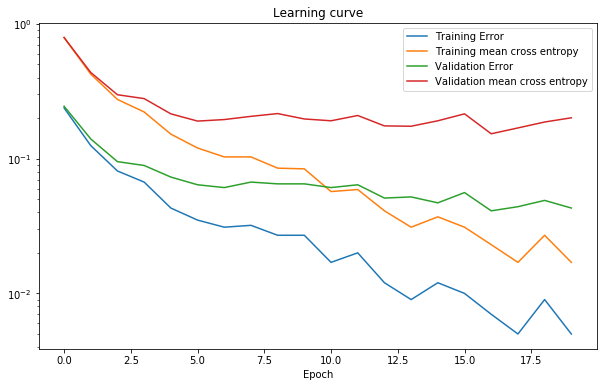

In [14]:
# Dump confusion matrix on given data set to file
def dump_confusion_matrix(x_data, y_data, file_name):
    num_examples = len(x_data)
    print("Dumping confusion matrix...")
    print()
    with tf.Session() as sess:
        saver.restore(sess, tf.train.latest_checkpoint('eval/'))
        confusion = np.zeros([42, 42])
        for offset in range(0, num_examples, batch_size):
            batch_x, batch_y = x_data[offset:offset+batch_size], y_data[offset:offset+batch_size]
            confusion += sess.run(confusion_matrix, feed_dict={x: batch_x, y: batch_y, keep_prob_conv: 1.0, keep_prob_full: 1.0})
        np.savetxt(file_name, confusion, delimiter=",")

# Dump mismatched sample images on given data set to file directory
def dump_mismatched_samples(x_data, y_data, file_directory):
    num_examples = len(x_data)
    print("Dumping mismatched images...")
    print()
    with tf.Session() as sess:
        saver.restore(sess, tf.train.latest_checkpoint('eval/'))
        for offset in range(0, num_examples, batch_size):
            batch_x, batch_y = x_data[offset:offset+batch_size], y_data[offset:offset+batch_size]
            matches = sess.run(tf.argmax(logits, 1), feed_dict={x: batch_x, y: batch_y, keep_prob_conv: 1.0, keep_prob_full: 1.0})
            if batch_x.shape[3] == 1:
                batch_x = drop_gray_dimension(batch_x)
            for i in range(len(matches)):
                if matches[i] != batch_y[i]:
                    imgdir = "{}/".format(file_directory)
                    if not os.path.exists(imgdir):
                        os.makedirs(imgdir)
                    scipy.misc.imsave("{}/{}_as_{}_idx_{}.jpg".format(imgdir, batch_y[i], matches[i], i), batch_x[i])


# Print accuracy on given data set
def print_accuracy(str, x_data, y_data):
    with tf.Session() as sess:
        saver.restore(sess, tf.train.latest_checkpoint('eval/'))
        test_accuracy = evaluate_accuracy(x_data, y_data)
        print("{} = {:.3f}".format(str, test_accuracy))


# Prints learning progress curves based on csv file
def print_learning_curve(file_name):
    learning_progress = pd.read_csv(file_name, sep=';', dtype=np.float32).as_matrix()
    fig, axis = plt.subplots(figsize=(10, 6))
    epochs = np.arange(len(learning_progress))
    a1, = axis.plot(epochs, 1. - learning_progress[:, 0], label='Training Error')
    l1, = axis.plot(epochs, learning_progress[:, 1], label='Training mean cross entropy')
    a2, = axis.plot(epochs, 1. - learning_progress[:, 2], label='Validation Error')   
    l2, = axis.plot(epochs, learning_progress[:, 3], label='Validation mean cross entropy')
    
    plt.legend(handles=[a1, l1, a2, l2])
    axis.set_yscale('log')
    axis.set_title("Learning curve")
    axis.set_xlabel('Epoch')
    axis.set_ylabel('')
    plt.show()       

#train_neural_network(x_train, y_train, True)
#dump_confusion_matrix(x_validation, y_validation, 'confusion.csv')
#dump_mismatched_samples(x_validation, y_validation, 'mismatched')
#print_accuracy("Training Accuracy", x_train, y_train)
#print_accuracy("Validation Accuracy",x_validation, y_validation)
#print_accuracy("Test Accuracy", x_test, y_test)
print_learning_curve('eval/base/learning.csv')

---

## Step 3: Test a Model on New Images


### Load and Output the Images

Web Images:
[000]:    1 x "Speed limit (20km/h)":


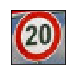


[001]:    1 x "Speed limit (30km/h)":


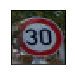


[002]:    1 x "Speed limit (50km/h)":


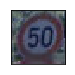


[003]:    1 x "Speed limit (60km/h)":


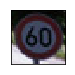


[004]:    1 x "Speed limit (70km/h)":


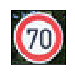


[005]:    1 x "Speed limit (80km/h)":


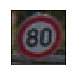


[006]:    1 x "End of speed limit (80km/h)":


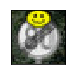


[007]:    1 x "Speed limit (100km/h)":


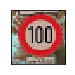


[008]:    1 x "Speed limit (120km/h)":


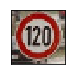


[009]:    1 x "No passing":


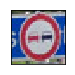


[010]:    1 x "No passing for vehicles over 3.5 metric tons":


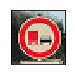


[011]:    1 x "Right-of-way at the next intersection":


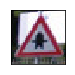


[012]:    1 x "Priority road":


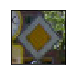


[013]:    1 x "Yield":


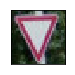


[014]:    1 x "Stop":


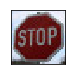


[015]:    1 x "No vehicles":


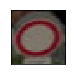


[016]:    1 x "Vehicles over 3.5 metric tons prohibited":


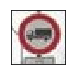


[017]:    1 x "No entry":


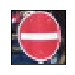


[018]:    1 x "General caution":


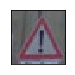


[019]:    1 x "Dangerous curve to the left":


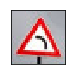


[020]:    1 x "Dangerous curve to the right":


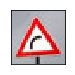


[021]:    1 x "Double curve":


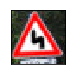


[022]:    1 x "Bumpy road":


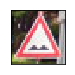


[023]:    1 x "Slippery road":


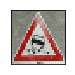


[024]:    1 x "Road narrows on the right":


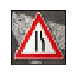


[025]:    1 x "Road work":


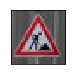


[026]:    1 x "Traffic signals":


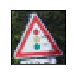


[027]:    1 x "Pedestrians":


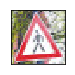


[028]:    1 x "Children crossing":


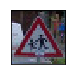


[029]:    1 x "Bicycles crossing":


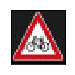


[030]:    1 x "Beware of ice/snow":


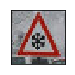


[031]:    1 x "Wild animals crossing":


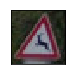


[032]:    1 x "End of all speed and passing limits":


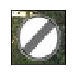


[033]:    1 x "Turn right ahead":


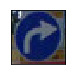


[034]:    1 x "Turn left ahead":


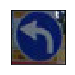


[035]:    1 x "Ahead only":


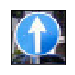


[036]:    1 x "Go straight or right":


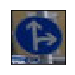


[037]:    1 x "Go straight or left":


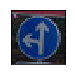


[038]:    1 x "Keep right":


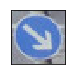


[039]:    1 x "Keep left":


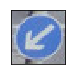


[040]:    1 x "Roundabout mandatory":


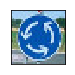


[041]:    1 x "End of no passing":


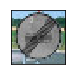


[042]:    1 x "End of no passing by vehicles over 3.5 metric tons":


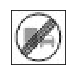

In [21]:
# Load images from directory
def load_web_images(file_directory):
    samples = []
    labels = []
    web_images = os.listdir(file_directory)
    image_files = []
    for image_file in web_images:
        if image_file.endswith(".jpg"):
            image_files.append(image_file)
    
    image_files.sort()
    for image_file in image_files:
        image = mpimg.imread("{}/{}".format(file_directory, image_file))
        class_idx = int(image_file[:2])
        samples.append(image)
        labels.append(class_idx)
    return np.array(samples), np.array(labels)

# Load images from web search/StreetView
x_web, y_web = load_web_images("data/web")  

print("Web Images:")
#fig = plt.figure(figsize=(11,4))
#fig.subplots_adjust(hspace = 0.1, wspace = 0.1)
#for i in range(len(x_web)):
#    axis = fig.add_subplot(4, 11, i + 1)
#    axis.tick_params(bottom='off', top='off', left='off', right='off', labelbottom='off', labeltop='off', labelleft='off', labelright='off')
#    axis.imshow(x_web[i])
#plt.show()
web_counts = np.stack(np.unique(y_web, return_counts=True), axis=1)
samples_web = select_samples(x_web, y_web, class_names, 1)
print_samples(class_names, web_counts, samples_web)



### Predict the Sign Type for Each Image

In [26]:
def print_results(x_data, y_data):
    num_examples = len(x_data)
    print("Extracting results...")
    print()
    with tf.Session() as sess:
        saver.restore(sess, tf.train.latest_checkpoint('eval/'))
        for offset in range(0, num_examples, batch_size):
            batch_x, batch_y = x_data[offset:offset+batch_size], y_data[offset:offset+batch_size]
            output = sess.run(tf.argmax(logits, 1), feed_dict={x: batch_x, y: batch_y, keep_prob_conv: 1.0, keep_prob_full: 1.0})
            for i in range(len(output)):
                if output[i] == batch_y[i]:
                    print("[{:>2}] detected as [{:>2}]: Correct".format(batch_y[i], output[i]))
                else:
                    print("[{:>2}] detected as [{:>2}]: Incorrect".format(batch_y[i], output[i]))

x_web = pre_proccess(x_web, y_web, "data/pre_web.p")
print_results(x_web, y_web)


Loading..
Normalizing..
Extracting results...

[ 0] detected as [ 0]: Correct
[ 1] detected as [ 1]: Correct
[ 2] detected as [ 2]: Correct
[ 3] detected as [ 3]: Correct
[ 4] detected as [ 4]: Correct
[ 5] detected as [ 5]: Correct
[ 6] detected as [ 6]: Correct
[ 7] detected as [ 7]: Correct
[ 8] detected as [ 8]: Correct
[ 9] detected as [ 9]: Correct
[10] detected as [10]: Correct
[11] detected as [11]: Correct
[12] detected as [12]: Correct
[13] detected as [13]: Correct
[14] detected as [14]: Correct
[15] detected as [15]: Correct
[16] detected as [16]: Correct
[17] detected as [17]: Correct
[18] detected as [18]: Correct
[19] detected as [19]: Correct
[20] detected as [20]: Correct
[21] detected as [21]: Correct
[22] detected as [22]: Correct
[23] detected as [23]: Correct
[24] detected as [24]: Correct
[25] detected as [25]: Correct
[26] detected as [26]: Correct
[27] detected as [27]: Correct
[28] detected as [28]: Correct
[29] detected as [29]: Correct
[30] detected as [30]: 

### Analyze Performance

In [28]:
print_accuracy("Web Accuracy", x_web, y_web)
print()


Web Accuracy = 0.977



### Output Top 5 Softmax Probabilities For Each Image Found on the Web

[000]: "Speed limit (20km/h)"


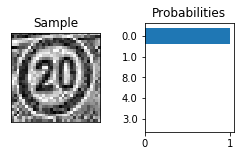

[001]: "Speed limit (30km/h)"


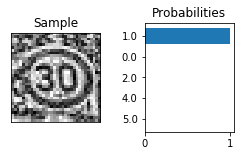

[002]: "Speed limit (50km/h)"


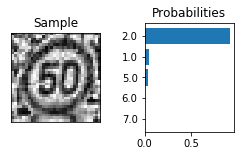

[003]: "Speed limit (60km/h)"


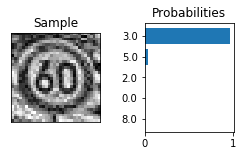

[004]: "Speed limit (70km/h)"


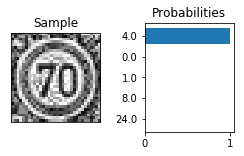

[005]: "Speed limit (80km/h)"


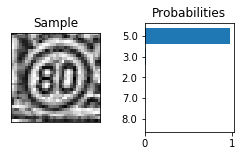

[006]: "End of speed limit (80km/h)"


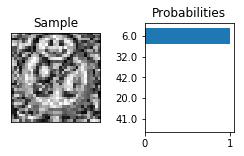

[007]: "Speed limit (100km/h)"


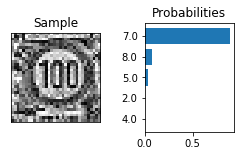

[008]: "Speed limit (120km/h)"


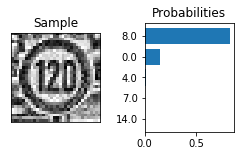

[009]: "No passing"


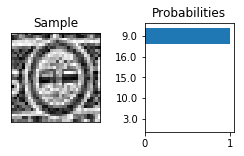

[010]: "No passing for vehicles over 3.5 metric tons"


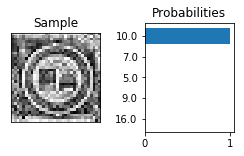

[011]: "Right-of-way at the next intersection"


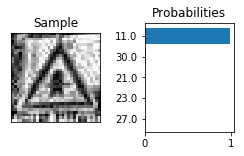

[012]: "Priority road"


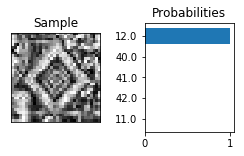

[013]: "Yield"


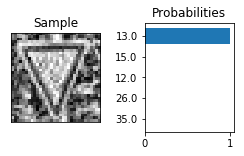

[014]: "Stop"


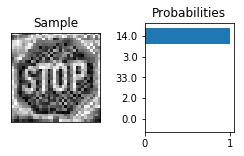

[015]: "No vehicles"


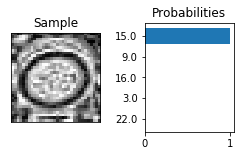

[016]: "Vehicles over 3.5 metric tons prohibited"


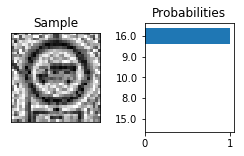

[017]: "No entry"


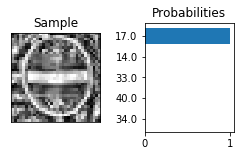

[018]: "General caution"


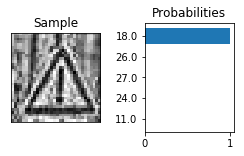

[019]: "Dangerous curve to the left"


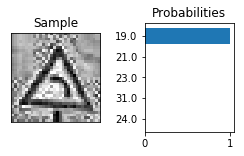

[020]: "Dangerous curve to the right"


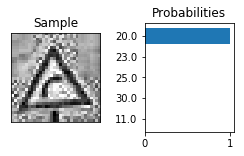

[021]: "Double curve"


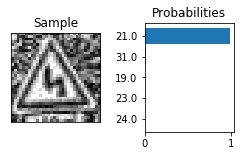

[022]: "Bumpy road"


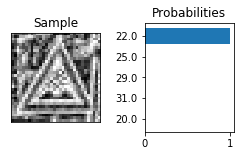

[023]: "Slippery road"


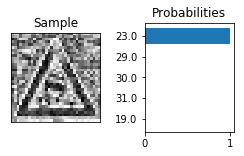

[024]: "Road narrows on the right"


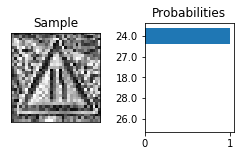

[025]: "Road work"


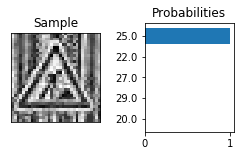

[026]: "Traffic signals"


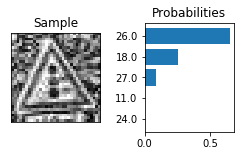

[027]: "Pedestrians"


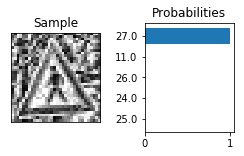

[028]: "Children crossing"


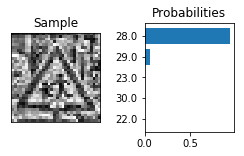

[029]: "Bicycles crossing"


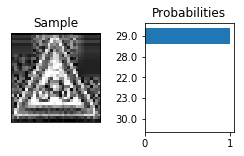

[030]: "Beware of ice/snow"


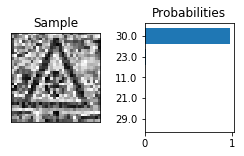

[031]: "Wild animals crossing"


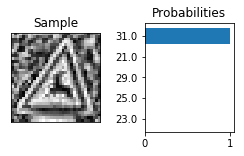

[032]: "End of all speed and passing limits"


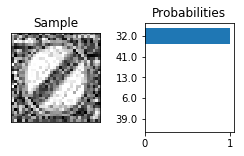

[033]: "Turn right ahead"


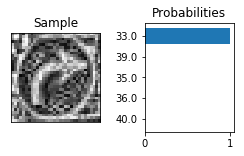

[034]: "Turn left ahead"


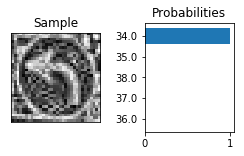

[035]: "Ahead only"


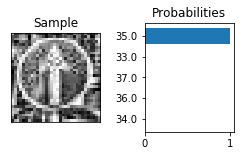

[036]: "Go straight or right"


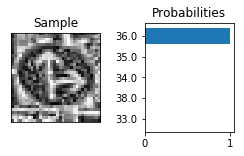

[037]: "Go straight or left"


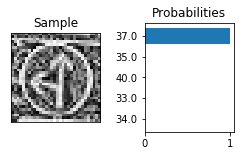

[038]: "Keep right"


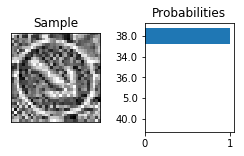

[039]: "Keep left"


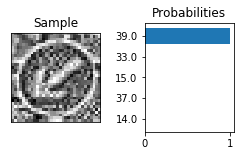

[040]: "Roundabout mandatory"


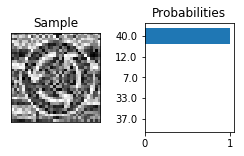

[041]: "End of no passing"


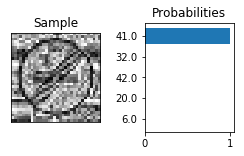

[042]: "End of no passing by vehicles over 3.5 metric tons"


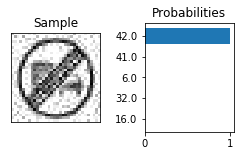

[043]: "Unknown"


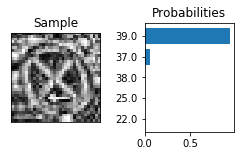

In [27]:
def print_sample_probabilities(axis, probabilities):    
    x = probabilities[:,1]
    y = probabilities[:,0]
    y_pos = np.arange(len(y))   
    axis.barh(y_pos, x)
    axis.set_yticks(y_pos)
    axis.set_yticklabels(y)
   # axis.set_xscale('log')
    #axis.xaxis.set_major_formatter(plttick.FormatStrFormatter('%.0f%%'))
    axis.invert_yaxis()  # labels read top-to-bottom
    axis.set_title('Probabilities') 


def print_top_probabilites(x_data, y_data, count=5):
    num_examples = len(x_data)
    with tf.Session() as sess:
        saver.restore(sess, tf.train.latest_checkpoint('eval/'))
        for offset in range(0, num_examples, batch_size):
            batch_x, batch_y = x_data[offset:offset+batch_size], y_data[offset:offset+batch_size] 
            output = sess.run(tf.nn.top_k(tf.nn.softmax(logits), k=count), feed_dict={x: batch_x, y: batch_y, keep_prob_conv: 1.0, keep_prob_full: 1.0})
            probabilities = np.stack((output.indices, output.values), axis=2)
            batch_gray = drop_gray_dimension(batch_x)
            for i in range(len(batch_gray)):
                class_idx = batch_y[i]
                name = class_names[class_idx][1] if class_idx < len(class_names) else "Unknown"
                print("[{:0>3}]: \"{}\"".format(class_idx, name))
                fig, axis = plt.subplots(nrows=1, ncols=2, figsize=(4, 2))
                fig.subplots_adjust(hspace = 0.1, wspace = 0.5)
                axis[0].imshow(batch_gray[i], cmap='gray')
                axis[0].set_title('Sample') 
                axis[0].tick_params(bottom='off', top='off', left='off', right='off', labelbottom='off', labeltop='off', labelleft='off', labelright='off')
                print_sample_probabilities(axis[1], probabilities[i])
                plt.show()

print_top_probabilites(x_web, y_web, 5)
print()




---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images


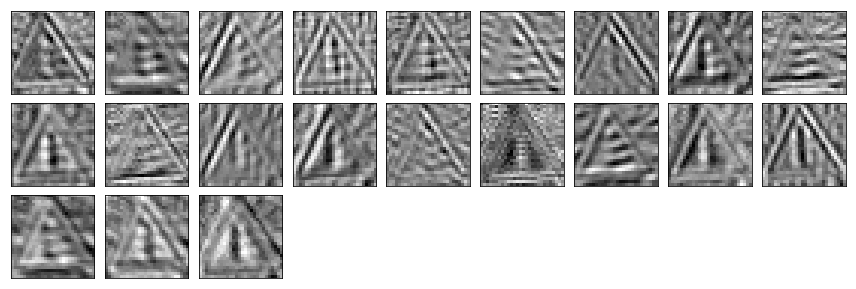

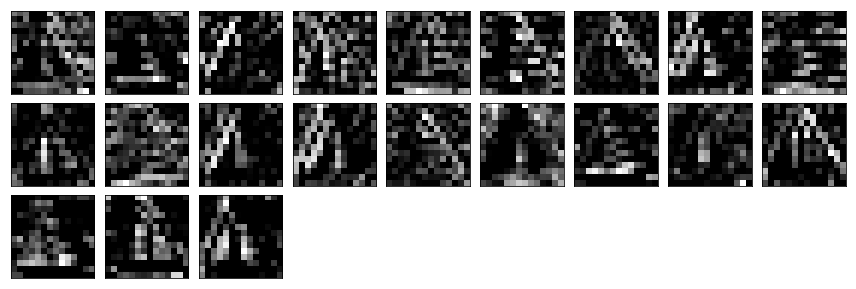

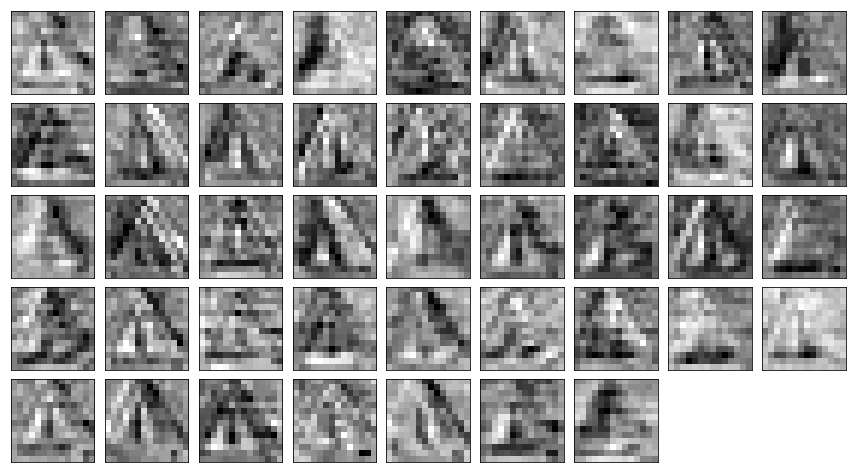

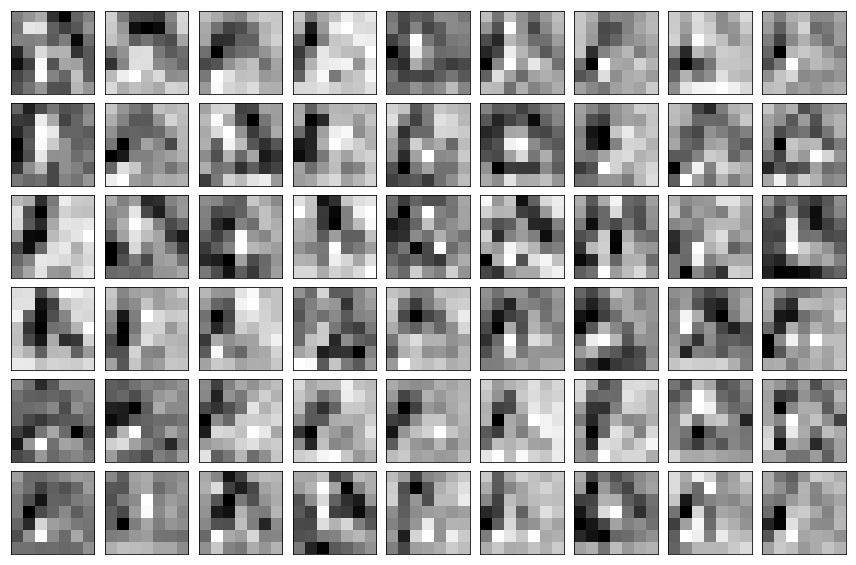

In [25]:
# Visualize your network's feature maps
def outputFeatureMap(image_input, var_name, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    with tf.Session() as sess:
        saver.restore(sess, tf.train.latest_checkpoint('eval/'))
        activation = tf.get_default_graph().get_operation_by_name(var_name).outputs[0].eval(session=sess,feed_dict={x : image_input, keep_prob_conv: 1.0, keep_prob_full: 1.0})
        featuremaps = activation.shape[3]
        fig = plt.figure(plt_num, figsize=(15,10))
        fig.subplots_adjust(hspace = 0.1, wspace = 0.1)
        for featuremap in range(featuremaps):
            plt.subplot(6,9, featuremap+1) # sets the number of feature maps to show on each row and column
            #plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
            plt.tick_params(bottom='off', top='off', left='off', right='off', labelbottom='off', labeltop='off', labelleft='off', labelright='off')
            if activation_min != -1 & activation_max != -1:
                plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
            elif activation_max != -1:
                plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
            elif activation_min !=-1:
                plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
            else:
                plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")
        plt.show()

# Dump learned images
outputFeatureMap([x_web[26]], 't_conv10')
outputFeatureMap([x_web[26]], 't_conv13')
outputFeatureMap([x_web[26]], 't_conv20')
outputFeatureMap([x_web[26]], 't_conv30')